# Batch normalisation layers

In this reading we will look at incorporating batch normalisation into our models and look at an example of how we do this in practice.

As usual, let's first import tensorflow.

In [1]:
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)


2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We will be working with the diabetes dataset that we have been using in this week's screencasts. 

Let's load and pre-process the dataset.

In [2]:
# Load the dataset

from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()

In [3]:
# Save the input and target variables

from sklearn.model_selection import train_test_split

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / (targets.std())

In [5]:
# Split the dataset into training and test datasets 

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

### Batch normalisation - defining the model

We can implement batch normalisation into our model by adding it in the same way as any other layer.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [7]:
# Build the model

model = Sequential([
    Dense(64, input_shape=[train_data.shape[1],], activation="relu"),
    BatchNormalization(),  # <- Batch normalisation layer
    Dropout(0.5),
    BatchNormalization(),  # <- Batch normalisation layer
    Dropout(0.5),
    Dense(256, activation='relu'),
])

# NB: We have not added the output layer because we still have more layers to add!

In [8]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
Total params: 17,856
Trainable params: 17,600
Non-trainable params: 256
__________________________________________________

Recall that there are some parameters and hyperparameters associated with batch normalisation.

* The hyperparameter **momentum** is the weighting given to the previous running mean when re-computing it with an extra minibatch. By **default**, it is set to 0.99.

* The hyperparameter **$\epsilon$** is used for numeric stability when performing the normalisation over the minibatch. By **default** it is set to 0.001.

* The parameters **$\beta$** and **$\gamma$** are used to implement an affine transformation after normalisation. By **default**, $\beta$ is an all-zeros vector, and $\gamma$ is an all-ones vector.

### Customising parameters
These can all be changed (along with various other properties) by adding optional arguments to `tf.keras.layers.BatchNormalization()`.

We can also specify the axis for batch normalisation. By default, it is set as -1.

Let's see an example.

In [10]:
# Add a customised batch normalisation layer

model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, 
    epsilon=0.005,
    axis = -1,
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
    gamma_initializer=tf.keras.initializers.Constant(value=0.9)
))

In [11]:
# Add the output layer

model.add(Dense(1))

## Compile and fit the model

Let's now compile and fit our model with batch normalisation, and track the progress on training and validation sets.

First we compile our model.

In [12]:
# Compile the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

Now we fit the model to the data.

In [13]:
# Train the model

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,verbose=False)

Finally, we plot training and validation loss and accuracy to observe how the accuracy of our model improves over time.

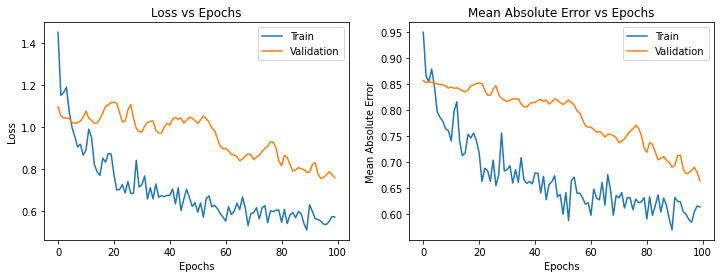

In [14]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

## Further reading and resources 
* https://keras.io/layers/normalization/
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization